### Model1 - Uses NASNet with dataset balancing

This model uses :
    1. NASNet as the base architecture 
    2. Batch size =40 and 100 epochs. 
    3. Uses processed (Histogram equalized) data 
    4. With balanced weights - used class_weights parameter during model fitting 
    5. Uses LR scheduler step decay.

In [19]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math

In [20]:
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/processed_data'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 40
NUM_EPOCHS = 100
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [21]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [22]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [23]:
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=[0.6, 0.9],
    zoom_range=[0.5,1.5],
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 

In [24]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2298 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [25]:
train_generator.samples 

2298

In [26]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [27]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [28]:

def create_nasnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(INPUT_SHAPE, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [29]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [31]:

callbacks_list  = [lr_scheduler]

This function calculates the weights for each class depending on the count for each class.

In [32]:
import numpy as np
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()
    for key in keys:
        score = (mu*total)/float(labels_dict[key])
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# labels_dict - counts for each class are from the respective folders.
labels_dict = {0: 826, 1: 822, 2: 395, 3: 827}

class_wt = create_class_weight(labels_dict)

Calculated class weights are applied to the model.

In [33]:
model = create_nasnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list,
    class_weight = class_wt
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/100
58/58 [==============================] - 100s 2s/step - loss: 3.1769 - accuracy: 0.5117 - val_loss: 3.1013 - val_accuracy: 0.4503

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/100
58/58 [==============================] - 96s 2s/step - loss: 3.0818 - accuracy: 0.5757 - val_loss: 2.4195 - val_accuracy: 0.5305

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/100
58/58 [==============================] - 96s 2s/step - loss: 2.9389 - accuracy: 0.6023 - val_loss: 2.7220 - val_accuracy: 0.5358

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
Epoch 4/100
58/58 [==============================] - 97s 2s/step - loss: 2.7398 - accuracy: 0.5905 - val_loss: 2.5478 - val_accuracy: 0.5550

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
Epoch 5/100
58/58 [==============================] - 96s 2s/step - loss: 2.9776 - accuracy: 0.5940 -


Epoch 00040: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 40/100
58/58 [==============================] - 97s 2s/step - loss: 0.9008 - accuracy: 0.7084 - val_loss: 0.7191 - val_accuracy: 0.6876

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 41/100
58/58 [==============================] - 97s 2s/step - loss: 0.8693 - accuracy: 0.7167 - val_loss: 0.7110 - val_accuracy: 0.6981

Epoch 00042: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 42/100
58/58 [==============================] - 97s 2s/step - loss: 0.8295 - accuracy: 0.7232 - val_loss: 0.7560 - val_accuracy: 0.6754

Epoch 00043: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 43/100
58/58 [==============================] - 97s 2s/step - loss: 0.8520 - accuracy: 0.7063 - val_loss: 0.7872 - val_accuracy: 0.6859

Epoch 00044: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 44/100
58/58 [==============================] - 97s 2s/step - loss: 0.8

58/58 [==============================] - 97s 2s/step - loss: 0.7574 - accuracy: 0.7372 - val_loss: 0.7620 - val_accuracy: 0.6579

Epoch 00079: LearningRateScheduler reducing learning rate to 0.00078125.
Epoch 79/100
58/58 [==============================] - 97s 2s/step - loss: 0.7180 - accuracy: 0.7372 - val_loss: 0.7275 - val_accuracy: 0.6684

Epoch 00080: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 80/100
58/58 [==============================] - 97s 2s/step - loss: 0.7333 - accuracy: 0.7276 - val_loss: 0.7175 - val_accuracy: 0.6876

Epoch 00081: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 81/100
58/58 [==============================] - 97s 2s/step - loss: 0.7354 - accuracy: 0.7406 - val_loss: 0.6746 - val_accuracy: 0.7068

Epoch 00082: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 82/100
58/58 [==============================] - 97s 2s/step - loss: 0.7336 - accuracy: 0.7424 - val_loss: 0.7317 - val_accuracy: 0.6789

Epo

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1056)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4228      
Total params: 4,273,944
Trainable params: 4,228
Non-trainable params: 4,269,716
_________________________________________________________________


In [35]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

10/10 [==============================] - 11s 1s/step - loss: 1.2337 - accuracy: 0.5964
Test Accuracy: 59.6446692943573%


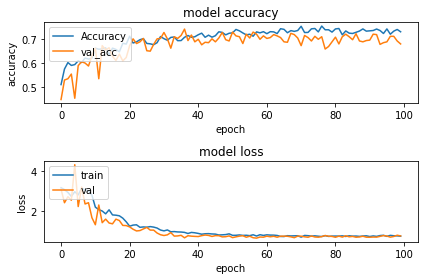

In [36]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()

In [37]:
import numpy as np

predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [38]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [39]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       0.54      0.37      0.44       100
meningioma_tumor       0.50      0.57      0.54       115
        no_tumor       0.73      0.76      0.74       105
 pituitary_tumor       0.61      0.70      0.65        74

        accuracy                           0.60       394
       macro avg       0.60      0.60      0.59       394
    weighted avg       0.59      0.60      0.59       394

